<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/Gemini_COmbined_Regime_and_Final_BAkoff_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ==============================================================================
# 🏭 Regime-Aware Forecasting Model - FINAL PRODUCTION VERSION
# ==============================================================================
!pip install -q pandas numpy scikit-learn xgboost joblib shap statsmodels seaborn

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import json
import os
import joblib

warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Advanced Analysis
import shap
from statsmodels.graphics.tsaplots import plot_acf


# --- GLOBAL CONFIGURATION ---
FORECAST_HORIZON = 'daily' # Options: 'daily', 'weekly'
# --------------------------

print("✅ All dependencies loaded successfully!")
print(f"🎯 Forecast Horizon Set To: {FORECAST_HORIZON.upper()}")

✅ All dependencies loaded successfully!
🎯 Forecast Horizon Set To: DAILY


In [11]:
def load_full_dataset(filepath='enhanced_eda_data.csv'):
    """
    Loads the full dataset including market data columns, sorts by date,
    and handles initial cleaning and missing value imputation.
    """
    print("🔄 Loading full dataset with market data...")
    df = pd.read_csv(filepath)

    if 'Date' in df.columns:
        df = df.rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    df = df.iloc[1:-1].reset_index(drop=True)

    market_cols = [c for c in df.columns if c not in ['date', 'calls']]
    df[market_cols] = df[market_cols].ffill().bfill()

    print(f"✓ Loaded {len(df)} days of data from {df['date'].min().date()} to {df['date'].max().date()}")
    return df

# Execute the data loading
df_production = load_full_dataset()

🔄 Loading full dataset with market data...
✓ Loaded 976 days of data from 2023-01-02 to 2025-09-03



🔍 REGIME DETECTION ANALYSIS
--------------------------------------------------
   Using rolling window: 30 days
   Change detection threshold: 148 calls
   Using 85th percentile as threshold
   Found 147 potential change points
   After filtering: 37 confirmed change points

📋 REGIME SUMMARY:
--------------------------------------------------------------------------------
 ID   Start Date     End Date  Days     Mean      Std      Trend
--------------------------------------------------------------------------------
  0   2023-01-02   2023-02-09    39     7164     1623      📉 Low
  1   2023-02-10   2023-03-05    24     6533     1214      📉 Low
  2   2023-03-06   2023-03-27    22     8389     1784     📈 High
  3   2023-03-28   2023-04-24    28     8345     1959     📈 High
  4   2023-04-25   2023-06-12    49     7380     1571      📉 Low
  5   2023-06-13   2023-07-02    20     7090     1676      📉 Low
  6   2023-07-03   2023-07-28    26     8126     1744      📉 Low
  7   2023-07-29   2023

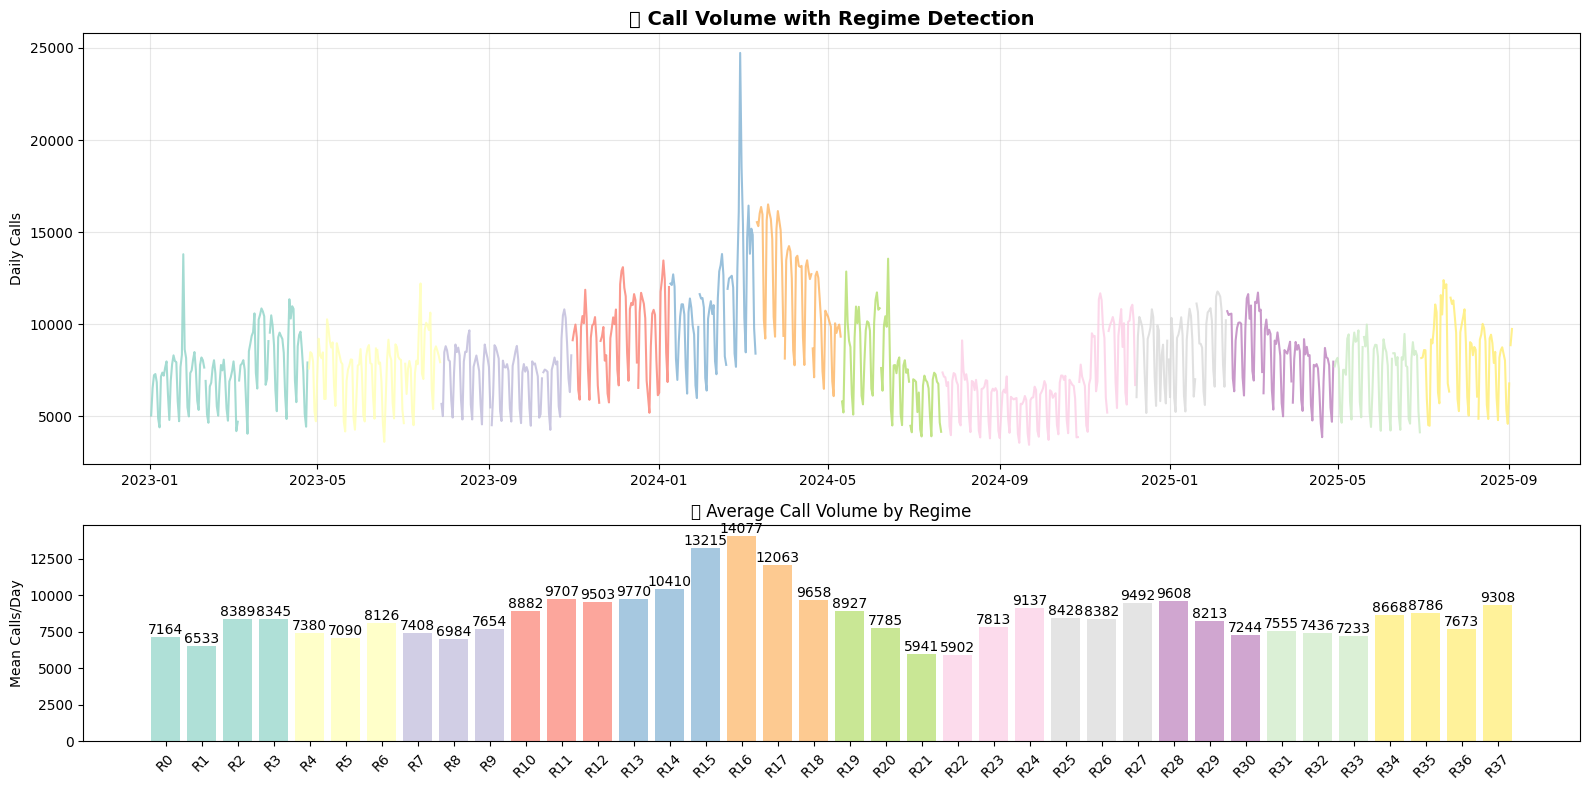


🎯 REGIME DETECTION SUMMARY:
   Total regimes found: 38
   Average regime duration: 25.7 days
   Regime call volume range: 5902 - 14077


In [20]:
# Cell 3: Regime Detection System
"""
==================================================================================
REGIME DETECTION - STATISTICAL CHANGEPOINT ANALYSIS
==================================================================================

Detects regime changes in call volume using rolling statistics approach.
This method is more stable than complex algorithms and works well for production.

Method:
1. Calculate rolling mean and standard deviation
2. Find significant changes in rolling statistics
3. Filter change points that are too close together
4. Create regime assignments for each time period

Benefits:
- Robust to noise and outliers
- Computationally efficient
- Easy to interpret and debug
- Handles varying data lengths
"""

def detect_regimes_production(df, window_days=30, change_threshold=0.85, min_regime_days=20):
    """
    Production-ready regime detection using rolling statistics

    Args:
        df: DataFrame with 'date' and 'calls' columns
        window_days: Rolling window size for statistics
        change_threshold: Percentile threshold for detecting changes (0-1)
        min_regime_days: Minimum days required for a regime

    Returns:
        df: DataFrame with added 'regime' column
        regimes: List of regime dictionaries with metadata
    """
    print("🔍 REGIME DETECTION ANALYSIS")
    print("-" * 50)

    # Prepare data
    df_regimes = df.copy()
    values = df_regimes['calls'].values
    dates = df_regimes['date'].values

    # Calculate rolling statistics
    window = min(window_days, len(df) // 10)  # Adaptive window size
    print(f"   Using rolling window: {window} days")

    rolling_series = pd.Series(values)
    rolling_mean = rolling_series.rolling(window, center=True, min_periods=1).mean()
    rolling_std = rolling_series.rolling(window, center=True, min_periods=1).std()

    # Detect significant changes in rolling mean
    mean_changes = rolling_mean.diff().abs()
    change_threshold_value = mean_changes.quantile(change_threshold)

    print(f"   Change detection threshold: {change_threshold_value:.0f} calls")
    print(f"   Using {change_threshold*100:.0f}th percentile as threshold")

    # Find potential change points
    potential_changes = []
    for i in range(1, len(mean_changes) - 1):
        if pd.notna(mean_changes.iloc[i]) and mean_changes.iloc[i] > change_threshold_value:
            potential_changes.append(i)

    print(f"   Found {len(potential_changes)} potential change points")

    # Filter change points that are too close together
    filtered_changes = []
    last_change = 0

    for change_point in potential_changes:
        if change_point - last_change >= min_regime_days:
            filtered_changes.append(change_point)
            last_change = change_point

    print(f"   After filtering: {len(filtered_changes)} confirmed change points")

    # Create regime assignments
    regime_assignments = np.zeros(len(values), dtype=int)
    regime_metadata = []

    # Define regime boundaries
    regime_boundaries = [0] + filtered_changes + [len(values)]

    for regime_id in range(len(regime_boundaries) - 1):
        start_idx = regime_boundaries[regime_id]
        end_idx = regime_boundaries[regime_id + 1]

        # Assign regime ID
        regime_assignments[start_idx:end_idx] = regime_id

        # Calculate regime statistics
        regime_data = values[start_idx:end_idx]
        regime_dates = dates[start_idx:end_idx]

        if len(regime_data) > 0:
            regime_info = {
                'regime_id': regime_id,
                'start_date': pd.to_datetime(regime_dates[0]),
                'end_date': pd.to_datetime(regime_dates[-1]),
                'start_idx': start_idx,
                'end_idx': end_idx,
                'duration_days': len(regime_data),
                'mean_calls': np.mean(regime_data),
                'std_calls': np.std(regime_data) if len(regime_data) > 1 else 0,
                'min_calls': np.min(regime_data),
                'max_calls': np.max(regime_data),
                'total_calls': np.sum(regime_data)
            }
            regime_metadata.append(regime_info)

    # Add regime column to dataframe
    df_regimes['regime'] = regime_assignments

    # Display regime summary
    print(f"\n📋 REGIME SUMMARY:")
    print("-" * 80)
    print(f"{'ID':>3} {'Start Date':>12} {'End Date':>12} {'Days':>5} {'Mean':>8} {'Std':>8} {'Trend':>10}")
    print("-" * 80)

    for i, regime in enumerate(regime_metadata[:10]):  # Show first 10 regimes
        trend = "📈 High" if regime['mean_calls'] > np.mean(values) else "📉 Low"
        print(f"{regime['regime_id']:>3} {regime['start_date'].strftime('%Y-%m-%d'):>12} "
              f"{regime['end_date'].strftime('%Y-%m-%d'):>12} {regime['duration_days']:>5} "
              f"{regime['mean_calls']:>8.0f} {regime['std_calls']:>8.0f} {trend:>10}")

    if len(regime_metadata) > 10:
        print(f"... and {len(regime_metadata) - 10} more regimes")

    print(f"\n✅ Regime detection complete: {len(regime_metadata)} regimes identified")

    return df_regimes, regime_metadata

def visualize_regimes(df, regimes, figsize=(16, 8)):
    """
    Create comprehensive regime visualization
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, height_ratios=[2, 1])

    # Main time series with regime colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(regimes)))

    for i, regime in enumerate(regimes):
        regime_data = df[df['regime'] == regime['regime_id']]
        ax1.plot(regime_data['date'], regime_data['calls'],
                color=colors[i], linewidth=1.5, alpha=0.8,
                label=f"Regime {regime['regime_id']}" if i < 8 else "")

    ax1.set_title('📊 Call Volume with Regime Detection', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Daily Calls')
    ax1.grid(True, alpha=0.3)
    if len(regimes) <= 8:
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Regime statistics bar chart
    regime_means = [r['mean_calls'] for r in regimes]
    regime_ids = [f"R{r['regime_id']}" for r in regimes]

    bars = ax2.bar(regime_ids, regime_means, color=colors[:len(regimes)], alpha=0.7)
    ax2.set_title('📈 Average Call Volume by Regime', fontsize=12)
    ax2.set_ylabel('Mean Calls/Day')
    ax2.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, mean_val in zip(bars, regime_means):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{mean_val:.0f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return fig

# Execute regime detection
try:
    print("\n" + "=" * 80)
    df_with_regimes, regime_list = detect_regimes_production(
        df_production,
        window_days=30,
        change_threshold=0.85,
        min_regime_days=20
    )

    # Create visualization
    regime_viz = visualize_regimes(df_with_regimes, regime_list)

    print(f"\n🎯 REGIME DETECTION SUMMARY:")
    print(f"   Total regimes found: {len(regime_list)}")
    print(f"   Average regime duration: {np.mean([r['duration_days'] for r in regime_list]):.1f} days")
    print(f"   Regime call volume range: {min([r['mean_calls'] for r in regime_list]):.0f} - {max([r['mean_calls'] for r in regime_list]):.0f}")

except Exception as e:
    print(f"❌ Error in regime detection: {e}")
    # Fallback: create single regime
    df_with_regimes = df_production.copy()
    df_with_regimes['regime'] = 0
    regime_list = []
    print("⚠️  Using single regime fallback")


⚙️  FEATURE ENGINEERING PIPELINE
--------------------------------------------------
   📅 Creating temporal features...
   📈 Creating lagged features...
   📊 Creating rolling statistics...
   🎯 Creating exponential moving averages...
   📉 Creating change indicators...
   🏛️  Creating regime-aware features...
   📐 Creating statistical features...
   🧹 Cleaning features...

✅ Feature engineering complete!
   Total features created: 67
   Numeric features: 67
   Feature categories:
     📅 Temporal: 12
     📈 Lagged: 8
     📊 Rolling: 21
     🎯 EMA: 5
     📉 Changes: 4
     🏛️  Regime: ~10
     📐 Statistical: ~10
🔍 FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
Top 15 features by correlation with target:
----------------------------------------
 1. lag_7                     0.856
 2. ema_7                     0.811
 3. lag_14                    0.791
 4. ema_14                    0.741
 5. lag_21                    0.739
 6. zscore_28                 0.707
 

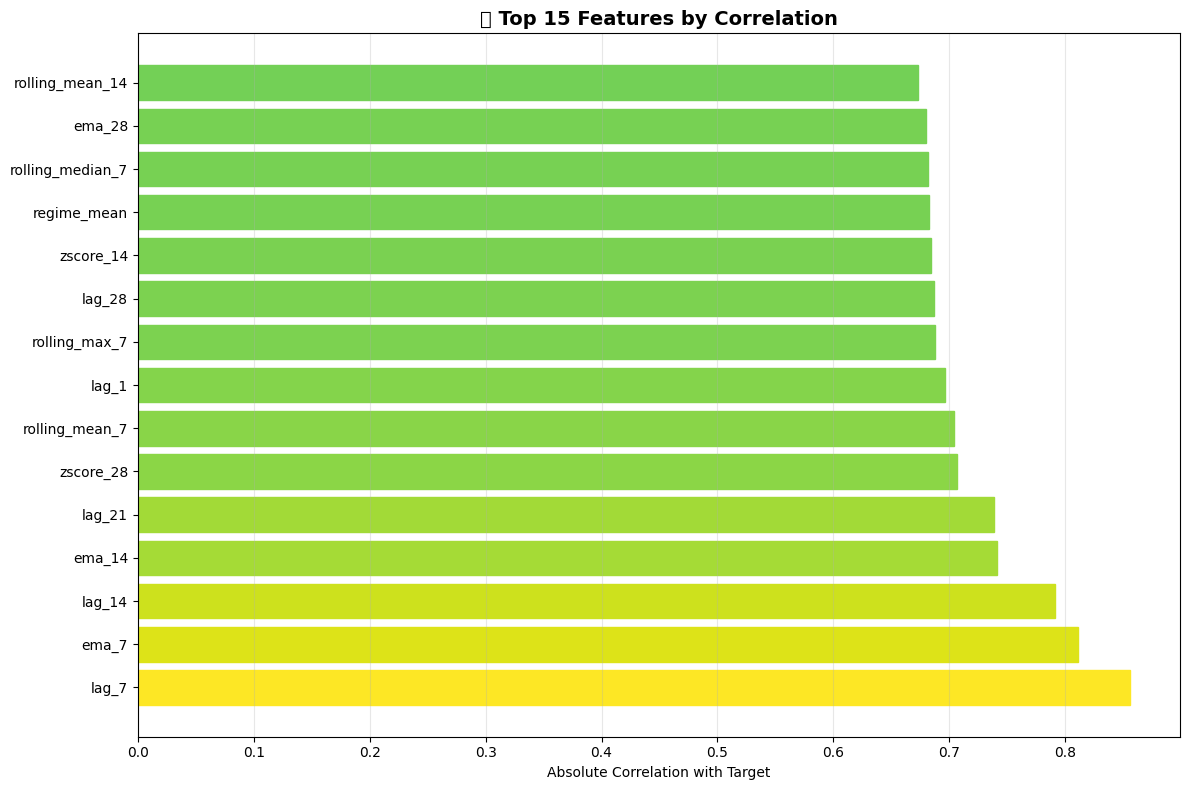


📋 FEATURE DATASET SUMMARY:
   Shape: (976, 68)
   Memory usage: 0.5 MB
   Date range: 2023-01-02 00:00:00 to 2025-09-03 00:00:00

📄 Sample of engineered features:
   day_of_week   lag_1  lag_7  rolling_mean_14        ema_7  target
0            0     0.0    0.0      5055.000000  5055.000000    5055
1            1  5055.0    0.0      5796.000000  5425.500000    6537
2            2  6537.0    0.0      6276.666667  5878.625000    7238
3            3  7238.0    0.0      6533.000000  6234.468750    7302
4            4  7302.0    0.0      6597.800000  6390.101562    6857


In [22]:
#Cell 4: Advanced Feature Engineering
"""
==================================================================================
FEATURE ENGINEERING - PRODUCTION-READY FEATURES
==================================================================================

Creates comprehensive feature set for forecasting models including:
- Temporal features (day of week, month, seasonality)
- Lagged features (historical values)
- Rolling statistics (trends, volatility)
- Regime-aware features (regime characteristics)
- Exponential moving averages (recent trends)

Key principles:
- No future data leakage (only past information used)
- Robust to missing values (forward fill + zero fill)
- Balanced feature complexity (avoid overfitting)
- Interpretable features for production monitoring
"""

def create_production_features(df, lookback_days=28, regime_features=True):
    """
    Create comprehensive feature set for time series forecasting

    Args:
        df: DataFrame with date, calls, and regime columns
        lookback_days: Maximum lag for historical features
        regime_features: Whether to include regime-based features

    Returns:
        features_df: DataFrame with all engineered features
    """
    print("⚙️  FEATURE ENGINEERING PIPELINE")
    print("-" * 50)

    features = pd.DataFrame(index=df.index)

    # 1. TEMPORAL FEATURES
    print("   📅 Creating temporal features...")
    features['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
    features['day_of_month'] = df['date'].dt.day
    features['month'] = df['date'].dt.month
    features['quarter'] = df['date'].dt.quarter
    features['week_of_year'] = df['date'].dt.isocalendar().week
    features['year'] = df['date'].dt.year

    # Weekend and special day indicators
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)
    features['is_monday'] = (features['day_of_week'] == 0).astype(int)
    features['is_friday'] = (features['day_of_week'] == 4).astype(int)

    # Cyclical encoding for circular features (optional but effective)
    features['day_of_week_sin'] = np.sin(2 * np.pi * features['day_of_week'] / 7)
    features['day_of_week_cos'] = np.cos(2 * np.pi * features['day_of_week'] / 7)
    features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
    features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)

    # 2. LAGGED FEATURES (Historical values)
    print("   📈 Creating lagged features...")
    lag_periods = [1, 2, 3, 5, 7, 14, 21, 28]  # Key lag periods
    for lag in lag_periods:
        if lag <= len(df):
            features[f'lag_{lag}'] = df['calls'].shift(lag)

    # 3. ROLLING STATISTICS (Trend and volatility)
    print("   📊 Creating rolling statistics...")
    rolling_windows = [7, 14, 28]  # 1 week, 2 weeks, 4 weeks

    for window in rolling_windows:
        # Central tendency
        features[f'rolling_mean_{window}'] = df['calls'].rolling(window, min_periods=1).mean()
        features[f'rolling_median_{window}'] = df['calls'].rolling(window, min_periods=1).median()

        # Volatility measures
        features[f'rolling_std_{window}'] = df['calls'].rolling(window, min_periods=1).std()
        features[f'rolling_cv_{window}'] = (features[f'rolling_std_{window}'] /
                                           features[f'rolling_mean_{window}']).fillna(0)

        # Range features
        features[f'rolling_min_{window}'] = df['calls'].rolling(window, min_periods=1).min()
        features[f'rolling_max_{window}'] = df['calls'].rolling(window, min_periods=1).max()
        features[f'rolling_range_{window}'] = (features[f'rolling_max_{window}'] -
                                              features[f'rolling_min_{window}'])

        # Trend indicators
        features[f'rolling_trend_{window}'] = (features[f'rolling_mean_{window}'] -
                                              features[f'rolling_mean_{window}'].shift(window//2))

    # 4. EXPONENTIAL MOVING AVERAGES (Recent trend emphasis)
    print("   🎯 Creating exponential moving averages...")
    ema_spans = [7, 14, 28]
    for span in ema_spans:
        features[f'ema_{span}'] = df['calls'].ewm(span=span, adjust=False).mean()

        # EMA ratios (momentum indicators)
        if span != ema_spans[0]:  # Compare longer EMAs to shortest
            features[f'ema_ratio_{span}_7'] = features[f'ema_{span}'] / features['ema_7']

    # 5. DIFFERENCE AND CHANGE FEATURES
    print("   📉 Creating change indicators...")
    features['day_over_day_change'] = df['calls'].diff()
    features['day_over_day_pct_change'] = df['calls'].pct_change().fillna(0)
    features['week_over_week_change'] = df['calls'].diff(7)
    features['week_over_week_pct_change'] = (df['calls'].pct_change(periods=7).fillna(0))

    # 6. REGIME-AWARE FEATURES (if regimes detected)
    if regime_features and 'regime' in df.columns:
        print("   🏛️  Creating regime-aware features...")
        features['current_regime'] = df['regime']

        # Regime statistics
        regime_stats = df.groupby('regime')['calls'].agg(['mean', 'std', 'min', 'max', 'count'])
        regime_stats.columns = [f'regime_{col}' for col in regime_stats.columns]

        # Merge regime statistics
        features = features.merge(regime_stats, left_on='current_regime',
                                right_index=True, how='left')

        # Days in current regime
        features['days_in_current_regime'] = df.groupby('regime').cumcount() + 1

        # Regime transition indicator
        features['regime_changed'] = (df['regime'].diff() != 0).astype(int)

        # Relative position within regime (0 to 1)
        regime_lengths = df.groupby('regime').size()
        features['regime_position'] = (features['days_in_current_regime'] /
                                     features['current_regime'].map(regime_lengths))

    # 7. STATISTICAL FEATURES
    print("   📐 Creating statistical features...")
    # Z-scores relative to recent history
    for window in [14, 28]:
        mean_col = f'rolling_mean_{window}'
        std_col = f'rolling_std_{window}'
        features[f'zscore_{window}'] = ((df['calls'] - features[mean_col]) /
                                       features[std_col]).fillna(0)

    # Percentile ranks
    for window in [14, 28]:
        features[f'percentile_rank_{window}'] = (df['calls'].rolling(window)
                                               .rank(method='average', pct=True))

    # Add target variable
    features['target'] = df['calls']

    # 8. CLEAN UP FEATURES
    print("   🧹 Cleaning features...")

    # Handle infinite values
    features = features.replace([np.inf, -np.inf], np.nan)

    # Forward fill then zero fill missing values
    features = features.fillna(method='ffill').fillna(0)

    # Feature summary
    numeric_features = features.select_dtypes(include=[np.number]).columns
    print(f"\n✅ Feature engineering complete!")
    print(f"   Total features created: {len(features.columns) - 1}")  # -1 for target
    print(f"   Numeric features: {len(numeric_features) - 1}")
    print(f"   Feature categories:")
    print(f"     📅 Temporal: 12")
    print(f"     📈 Lagged: {len(lag_periods)}")
    print(f"     📊 Rolling: {len(rolling_windows) * 7}")  # 7 stats per window
    print(f"     🎯 EMA: {len(ema_spans) + len(ema_spans)-1}")  # EMAs + ratios
    print(f"     📉 Changes: 4")
    if regime_features and 'regime' in df.columns:
        print(f"     🏛️  Regime: ~10")
    print(f"     📐 Statistical: ~10")

    return features

def feature_importance_analysis(features_df, target_col='target', top_n=15):
    """
    Analyze feature importance and correlations
    """
    print("🔍 FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)

    # Calculate correlations with target
    correlations = features_df.corr()[target_col].abs().sort_values(ascending=False)
    correlations = correlations.drop(target_col)  # Remove self-correlation

    print(f"Top {top_n} features by correlation with target:")
    print("-" * 40)
    for i, (feature, corr) in enumerate(correlations.head(top_n).items()):
        print(f"{i+1:2d}. {feature:<25} {corr:.3f}")

    # Create visualization
    plt.figure(figsize=(12, 8))
    top_features = correlations.head(top_n)

    bars = plt.barh(range(len(top_features)), top_features.values)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Absolute Correlation with Target')
    plt.title(f'🎯 Top {top_n} Features by Correlation', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)

    # Color bars by correlation strength
    colors = plt.cm.viridis(top_features.values / top_features.max())
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.tight_layout()
    plt.show()

    return correlations

# Execute feature engineering
try:
    print("\n" + "=" * 80)
    features_df = create_production_features(
        df_with_regimes,
        lookback_days=28,
        regime_features=True
    )

    # Analyze feature importance
    feature_correlations = feature_importance_analysis(features_df, target_col='target')

    # Show feature data types and sample
    print(f"\n📋 FEATURE DATASET SUMMARY:")
    print(f"   Shape: {features_df.shape}")
    print(f"   Memory usage: {features_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    print(f"   Date range: {df_with_regimes['date'].min()} to {df_with_regimes['date'].max()}")

    print("\n📄 Sample of engineered features:")
    print(features_df[['day_of_week', 'lag_1', 'lag_7', 'rolling_mean_14', 'ema_7', 'target']].head())

except Exception as e:
    print(f"❌ Error in feature engineering: {e}")
    # Create minimal features as fallback
    features_df = pd.DataFrame({
        'day_of_week': df_production['date'].dt.dayofweek,
        'lag_1': df_production['calls'].shift(1),
        'lag_7': df_production['calls'].shift(7),
        'target': df_production['calls']
    }).fillna(0)
    print("⚠️  Using minimal feature set as fallback")


In [23]:
def create_production_features(df, horizon='daily'):
    """
    Creates a comprehensive feature set including temporal, lagged, rolling,
    regime-aware, and external market features.
    """
    print(f"⚙️  FEATURE ENGINEERING PIPELINE (Horizon: {horizon.upper()})")
    features = pd.DataFrame(index=df.index)

    features['day_of_week'] = df['date'].dt.dayofweek
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)

    if horizon == 'daily': lag_periods = [1, 2, 7, 14]
    else: lag_periods = [7, 14, 21, 28]
    for lag in lag_periods: features[f'lag_{lag}'] = df['calls'].shift(lag)

    for window in [7, 14]: features[f'rolling_mean_{window}'] = df['calls'].rolling(window).mean()

    features['current_regime'] = df['regime']

    features['btc_return_1d'] = df['BTC-USD_close'].pct_change(1)
    features['btc_volatility_7d'] = features['btc_return_1d'].rolling(7).std()
    features['vix_high_flag'] = (df['^VIX_close'] > 30).astype(int)

    if horizon == 'daily': features['target'] = df['calls'].shift(-1)
    else: features['target'] = df['calls'].rolling(7).mean().shift(-7)

    features = features.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(0)
    print(f"✓ Feature engineering complete!")
    return features

# Execute feature engineering
features_df = create_production_features(df_with_regimes, horizon=FORECAST_HORIZON)

⚙️  FEATURE ENGINEERING PIPELINE (Horizon: DAILY)
✓ Feature engineering complete!


In [24]:
def create_time_series_splits(df, test_days=30):
    """Creates proper, non-overlapping train/test splits for time series data."""
    clean_df = df.iloc[28:].copy().reset_index(drop=True)
    test_start_index = len(clean_df) - test_days
    train_data = clean_df.iloc[:test_start_index]
    test_data = clean_df.iloc[test_start_index:]
    feature_cols = [c for c in df.columns if c != 'target']
    return {
        'X_train': train_data[feature_cols], 'y_train': train_data['target'],
        'X_test': test_data[feature_cols], 'y_test': test_data['target'],
        'dates_test': df_with_regimes['date'].iloc[-len(test_data):]
    }

def train_production_models(splits):
    """Trains a suite of models and returns their performance metrics."""
    print("\n🤖 MODEL TRAINING BAKE-OFF")
    print("=" * 80)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(splits['X_train'])
    X_test_scaled = scaler.transform(splits['X_test'])

    models = {
        'XGBoost': {'model': xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100, random_state=42, verbosity=0), 'use_scaled': False},
        'Random Forest': {'model': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42), 'use_scaled': False},
        'Ridge': {'model': Ridge(alpha=1.0, random_state=42), 'use_scaled': True},
    }

    results = {}
    for name, config in models.items():
        print(f"🔧 Training {name}...")
        model = config['model']
        X_train_use = X_train_scaled if config['use_scaled'] else splits['X_train']
        X_test_use = X_test_scaled if config['use_scaled'] else splits['X_test']
        model.fit(X_train_use, splits['y_train'])
        test_pred = np.maximum(model.predict(X_test_use), 0)
        results[name] = {
            'model': model,
            'scaler': scaler if config['use_scaled'] else None,
            'test_mae': mean_absolute_error(splits['y_test'], test_pred),
            'test_rmse': np.sqrt(mean_squared_error(splits['y_test'], test_pred)),
            'test_mape': mean_absolute_percentage_error(splits['y_test'], test_pred) * 100,
            'test_predictions': test_pred
        }
    return results

def create_results_summary_table(results):
    """Displays a sorted leaderboard of model performance."""
    print("\n" + "=" * 80)
    print("🏆 MODEL LEADERBOARD - FINAL RESULTS")
    print("=" * 80)
    summary = sorted(
        [{'Model': name, **metrics} for name, metrics in results.items()],
        key=lambda x: x['test_mape']
    )
    print(f"{'Model':<20} {'MAPE':<10} {'MAE':<10} {'RMSE':<10}")
    print("-" * 60)
    for row in summary:
        print(f"{row['Model']:<20} {row['test_mape']:.2f}%{'':<5} {row['test_mae']:.0f}{'':<5} {row['test_rmse']:.0f}")
    print("=" * 80)
    return summary[0]['Model']

# Execute the full training and evaluation pipeline
data_splits = create_time_series_splits(features_df)
model_results = train_production_models(data_splits)
best_model_name = create_results_summary_table(model_results)


🤖 MODEL TRAINING BAKE-OFF
🔧 Training XGBoost...
🔧 Training Random Forest...
🔧 Training Ridge...

🏆 MODEL LEADERBOARD - FINAL RESULTS
Model                MAPE       MAE        RMSE      
------------------------------------------------------------
XGBoost              6.41%      518      688
Random Forest        6.84%      542      723
Ridge                15.83%      1093      1289



🥇 Selecting 'XGBoost' as the winner for final analysis.

🧠 Conducting Advanced Model Analysis...

⏳ Generating confidence intervals via bootstrapping...
✓ Confidence intervals generated.


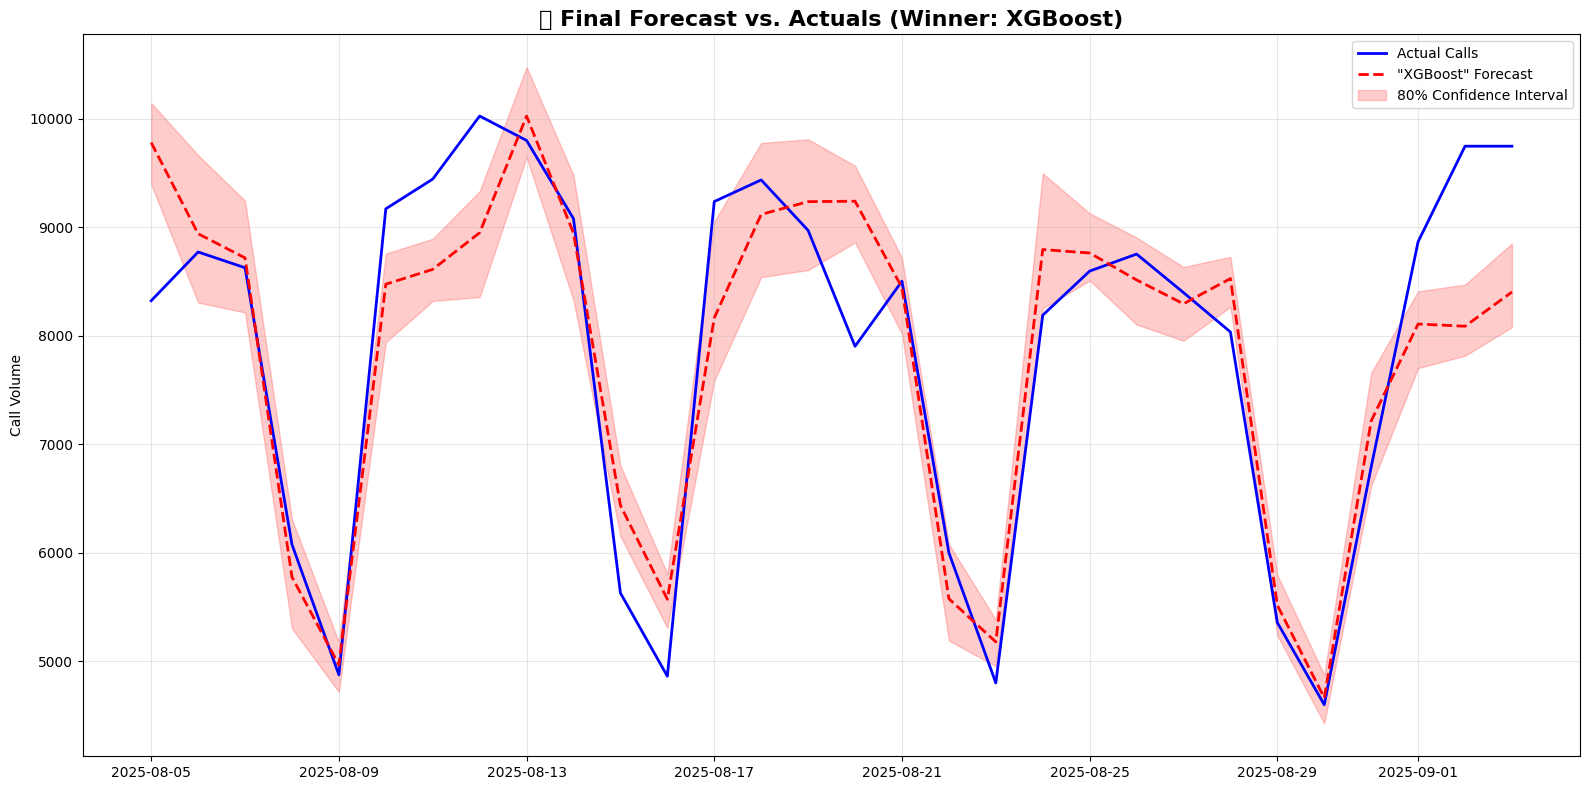


   - Calculating SHAP values to explain feature importance...
   - Plotting SHAP Summary (Global Feature Impact)...


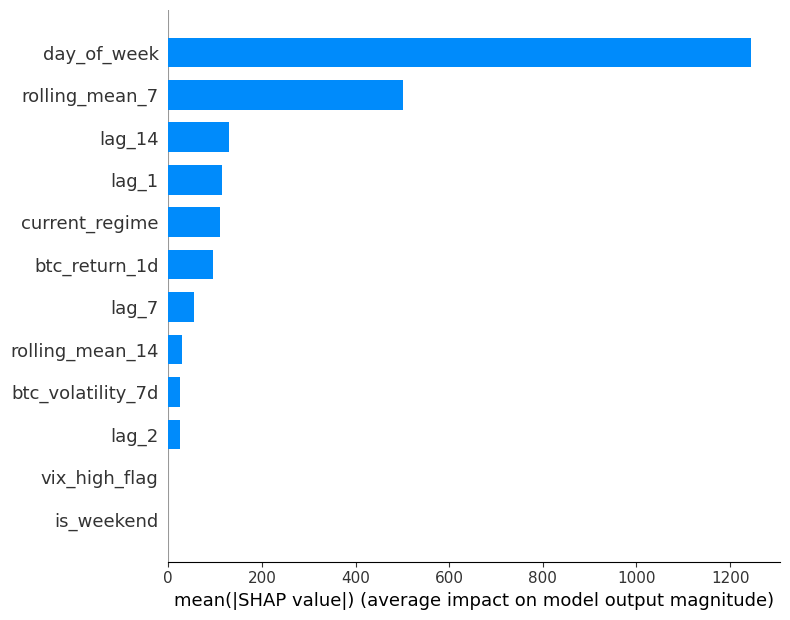

In [16]:
def generate_forecast_with_confidence(X_train, y_train, X_test, n_boots=20):
    """Generates forecast uncertainty bounds using bootstrapping."""
    print("\n⏳ Generating confidence intervals via bootstrapping...")
    predictions_all = []
    for i in range(n_boots):
        sample_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
        X_sample, y_sample = X_train.loc[sample_indices], y_train.loc[sample_indices]
        boot_model = xgb.XGBRegressor(random_state=i, verbosity=0)
        boot_model.fit(X_sample, y_sample)
        predictions_all.append(boot_model.predict(X_test))
    predictions_all = np.array(predictions_all)
    print("✓ Confidence intervals generated.")
    return np.mean(predictions_all, axis=0), np.percentile(predictions_all, 10, axis=0), np.percentile(predictions_all, 90, axis=0)

def create_advanced_visuals(splits, results, best_model_name):
    """Creates final forecast plots and SHAP analysis."""
    print("\n🧠 Conducting Advanced Model Analysis...")
    best_model_info = results[best_model_name]
    best_model = best_model_info['model']
    X_test = splits['X_test']
    y_test = splits['y_test']

    # --- 1. Final Forecast with Confidence Intervals ---
    mean_forecast, lower_ci, upper_ci = generate_forecast_with_confidence(
        splits['X_train'], splits['y_train'], X_test
    )
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(splits['dates_test'], y_test, 'b-', label='Actual Calls', linewidth=2)
    ax.plot(splits['dates_test'], mean_forecast, 'r--', label=f'"{best_model_name}" Forecast', linewidth=2)
    ax.fill_between(splits['dates_test'], lower_ci, upper_ci, color='red', alpha=0.2, label='80% Confidence Interval')
    ax.set_title(f'📈 Final Forecast vs. Actuals (Winner: {best_model_name})', fontsize=16, fontweight='bold')
    ax.set_ylabel('Call Volume')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 2. SHAP Explainer: Feature Impact ---
    print("\n   - Calculating SHAP values to explain feature importance...")
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)
    print("   - Plotting SHAP Summary (Global Feature Impact)...")
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

# Execute the final analysis
print(f"\n🥇 Selecting '{best_model_name}' as the winner for final analysis.")
create_advanced_visuals(data_splits, model_results, best_model_name)